[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-5/memoryschema_collection.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/59971006-lesson-4-memory-schema-collection)

# 컬렉션 스키마를 사용하는 챗봇

## 복습

우리는 챗봇을 확장하여 의미 기억을 단일 [사용자 프로필](https://langchain-ai.github.io/langgraph/concepts/memory/#profile)에 저장하도록 만들었습니다.

또한, 새로운 정보로 이 스키마를 업데이트하기 위한 [Trustcall](https://github.com/hinthornw/trustcall) 라이브러리를 소개했습니다.

## 목표

때로는 단일 프로필이 아닌 [컬렉션](https://docs.google.com/presentation/d/181mvjlgsnxudQI6S3ritg9sooNyu4AcLLFH1UK0kIuk/edit#slide=id.g30eb3c8cf10_0_200)에 메모리를 저장하고 싶을 때가 있습니다.

여기서는 챗봇을 업데이트하여 [메모리를 컬렉션에 저장](https://langchain-ai.github.io/langgraph/concepts/memory/#collection)하도록 만들 것입니다.

또한 [Trustcall](https://github.com/hinthornw/trustcall)을 사용하여 이 컬렉션을 업데이트하는 방법도 보여드리겠습니다.

In [1]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph trustcall langchain_core

In [2]:
from dotenv import load_dotenv

load_dotenv("../.env", override=True)

True

In [ ]:
import os
import getpass


def _set_env(var: str):
    env_value = os.environ.get(var)
    if not env_value:
        env_value = getpass.getpass(f"{var}: ")

    os.environ[var] = env_value


_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## 컬렉션 스키마 정의하기

고정된 프로필 구조에 사용자 정보를 저장하는 대신, 사용자 상호작용에 대한 메모리를 저장하기 위해 유연한 컬렉션 스키마를 생성할 것입니다.

각 메모리는 우리가 기억하고 싶은 주요 정보를 위한 단일 `content` 필드를 가진 별도의 항목으로 저장될 것입니다.

이 접근 방식을 통해 사용자에 대해 더 많이 알게 됨에 따라 성장하고 변경될 수 있는 개방형 메모리 컬렉션을 구축할 수 있습니다.

컬렉션 스키마는 [Pydantic](https://docs.pydantic.dev/latest/) 객체로 정의할 수 있습니다.

In [ ]:
from pydantic import BaseModel, Field


class Memory(BaseModel):
    content: str = Field(
        description="메모리의 주요 내용입니다. 예: 사용자가 프랑스어 학습에 관심을 보였습니다."
    )


class MemoryCollection(BaseModel):
    memories: list[Memory] = Field(description="사용자에 대한 메모리 목록입니다.")

In [5]:
_set_env("OPENAI_API_KEY")

LangChain의 [채팅 모델](https://python.langchain.com/docs/concepts/chat_models/) 인터페이스의 [`with_structured_output`](https://python.langchain.com/docs/concepts/structured_outputs/#recommended-usage) 메서드를 사용하여 구조화된 출력을 강제할 수 있습니다.

In [55]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI

# 모델 초기화
model = ChatOpenAI(model="gpt-4.1-mini", temperature=0)

# 모델에 스키마 바인딩
model_with_structure = model.with_structured_output(MemoryCollection)

# 스키마와 일치하는 구조화된 출력을 생성하기 위해 모델 호출
memory_collection = model_with_structure.invoke(
    [HumanMessage("제 이름은 Lance입니다. 그리고 저는 자전거 타는 것을 좋아합니다.")]
)
memory_collection.memories

[Memory(content='사용자 이름은 Lance입니다.'),
 Memory(content='Lance는 자전거 타는 것을 좋아합니다.')]

`model_dump()`를 사용하여 Pydantic 모델 인스턴스를 파이썬 딕셔너리로 직렬화할 수 있습니다.

In [33]:
memory_collection.memories[0].model_dump()

{'content': '사용자의 이름은 Lance이다.'}

각 메모리의 딕셔너리 표현을 저장소에 저장합니다.

In [34]:
import uuid
from langgraph.store.memory import InMemoryStore

# 인메모리 저장소 초기화
in_memory_store = InMemoryStore()

# 저장할 메모리의 네임스페이스
user_id = "1"
namespace_for_memory = (user_id, "memories")

# 네임스페이스에 메모리를 키와 값으로 저장
key = str(uuid.uuid4())
value = memory_collection.memories[0].model_dump()
in_memory_store.put(namespace_for_memory, key, value)

key = str(uuid.uuid4())
value = memory_collection.memories[1].model_dump()
in_memory_store.put(namespace_for_memory, key, value)

저장소에서 메모리를 검색합니다.

In [35]:
# 검색
for m in in_memory_store.search(namespace_for_memory):
    print(m.dict())

{'namespace': ['1', 'memories'], 'key': '722c5de4-8d39-47f4-a330-2747961b087b', 'value': {'content': '사용자의 이름은 Lance이다.'}, 'created_at': '2025-10-02T08:33:54.899283+00:00', 'updated_at': '2025-10-02T08:33:54.899284+00:00', 'score': None}
{'namespace': ['1', 'memories'], 'key': '471c0f0b-6f69-4cd0-99d2-61bda01cc747', 'value': {'content': '사용자는 자전거 타는 것을 좋아한다.'}, 'created_at': '2025-10-02T08:33:54.899328+00:00', 'updated_at': '2025-10-02T08:33:54.899329+00:00', 'score': None}


## 컬렉션 스키마 업데이트하기

지난 강의에서 프로필 스키마를 업데이트할 때의 어려움에 대해 논의했습니다.

이는 컬렉션의 경우에도 마찬가지입니다!

우리는 컬렉션에 새로운 메모리를 추가하고, 기존 메모리를 수정하는 기능이 모두 필요합니다.

이제 [Trustcall](https://github.com/hinthornw/trustcall)이 컬렉션 업데이트에도 사용될 수 있음을 보여드리겠습니다.

이를 통해 새로운 메모리를 추가하는 것과 [컬렉션 내의 기존 메모리를 업데이트하는 것](https://github.com/hinthornw/trustcall?tab=readme-ov-file#simultanous-updates--insertions)이 모두 가능해집니다.

Trustcall을 사용하여 새로운 추출기를 정의해 보겠습니다.

이전과 마찬가지로, 각 메모리에 대한 스키마인 `Memory`를 제공합니다.

그리고 추출기가 컬렉션에 새로운 메모리를 삽입할 수 있도록 `enable_inserts=True`를 설정할 수 있습니다.

In [ ]:
from trustcall import create_extractor

# 추출기 생성
trustcall_extractor = create_extractor(
    model,
    tools=[Memory],
    tool_choice="Memory",
    enable_inserts=True,  # 컬렉션에 새로운 메모리 삽입 가능
)

In [37]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

# 지시사항
instruction = """다음 대화에서 메모리를 추출하세요:"""

# 대화
conversation = [
    HumanMessage(content="안녕하세요, 저는 Lance입니다."),
    AIMessage(content="만나서 반갑습니다, Lance."),
    HumanMessage(content="오늘 아침 샌프란시스코에서 즐겁게 자전거를 탔습니다."),
]

# 추출기 호출
result = trustcall_extractor.invoke(
    {
        "messages": [SystemMessage(content=instruction)] + conversation,
    }
)

In [38]:
result

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5P9dVOAl75I4dw15WwyVfNxi', 'function': {'arguments': '{"content":"사용자 이름은 Lance입니다. 오늘 아침 샌프란시스코에서 자전거를 타며 즐거운 시간을 보냈습니다."}', 'name': 'Memory'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 36, 'prompt_tokens': 141, 'total_tokens': 177, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_9f0c66f9ae', 'id': 'chatcmpl-CM935AkSUVhkZ76MzzJdYS7XtKHxe', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--c9f42f11-1985-43fc-b2f1-0c1ee12fa17f-0', tool_calls=[{'name': 'Memory', 'args': {'content': '사용자 이름은 Lance입니다. 오늘 아침 샌프란시스코에서 자전거를 타며 즐거운 시간을 보냈습니다.'}, 'id': 'call_5P9dVOAl75I4dw15WwyVfNxi', 'type': 'tool_call'}], usage_

In [ ]:
# 메시지에는 도구 호출이 포함됩니다
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_5P9dVOAl75I4dw15WwyVfNxi)
 Call ID: call_5P9dVOAl75I4dw15WwyVfNxi
  Args:
    content: 사용자 이름은 Lance입니다. 오늘 아침 샌프란시스코에서 자전거를 타며 즐거운 시간을 보냈습니다.


In [ ]:
# 응답(Responses)에는 스키마를 준수하는 메모리가 포함되어 있습니다.
for m in result["responses"]:
    print(m)

content='사용자 이름은 Lance입니다. 오늘 아침 샌프란시스코에서 자전거를 타며 즐거운 시간을 보냈습니다.'


In [ ]:
# 메타데이터에는 도구 호출(tool call)이 포함됩니다.
for m in result["response_metadata"]:
    print(m)

{'id': 'call_5P9dVOAl75I4dw15WwyVfNxi'}


In [44]:
# 대화 업데이트
updated_conversation = [
    AIMessage(content="좋네요, 그 후에는 무엇을 하셨나요?"),
    HumanMessage(content="Tartine에 가서 크루아상을 먹었어요."),
    AIMessage(content="또 무슨 생각하고 계신가요?"),
    HumanMessage(
        content="일본에 대해 생각하고 있었는데, 이번 겨울에 다시 가고 싶어요!"
    ),
]

# 지시사항 업데이트
system_msg = (
    """다음 대화를 기반으로 기존 메모리를 업데이트하고 새로운 메모리를 생성하세요:"""
)

# 기존 메모리를 저장하고, ID, 키(도구 이름), 값을 부여합니다
tool_name = "Memory"
existing_memories = (
    [
        (str(i), tool_name, memory.model_dump())
        for i, memory in enumerate(result["responses"])
    ]
    if result["responses"]
    else None
)
existing_memories

[('0',
  'Memory',
  {'content': '사용자 이름은 Lance입니다. 오늘 아침 샌프란시스코에서 자전거를 타며 즐거운 시간을 보냈습니다.'})]

In [ ]:
# 업데이트된 대화와 기존 메모리를 사용하여 추출기를 호출합니다.
result = trustcall_extractor.invoke(
    {
        "messages": updated_conversation,
        "existing": existing_memories,
    }
)

In [ ]:
# 모델의 메시지는 두 개의 도구 호출(tool call)이 이루어졌음을 나타냅니다.
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_sBu9ROfPwdeCOalZ53P4Flzi)
 Call ID: call_sBu9ROfPwdeCOalZ53P4Flzi
  Args:
    content: 사용자 이름은 Lance입니다. 오늘 아침 샌프란시스코에서 자전거를 타며 즐거운 시간을 보냈습니다. 그 후 Tartine에 가서 크루아상을 먹었습니다. 그리고 일본에 대해 생각하고 있었는데, 이번 겨울에 다시 가고 싶어요!


In [ ]:
# 응답에는 스키마를 준수하는 메모리가 포함되어 있습니다.
for m in result["responses"]:
    print(m)

content='사용자 이름은 Lance입니다. 오늘 아침 샌프란시스코에서 자전거를 타며 즐거운 시간을 보냈습니다. 그 후 Tartine에 가서 크루아상을 먹었습니다. 그리고 일본에 대해 생각하고 있었는데, 이번 겨울에 다시 가고 싶어요!'


이는 `json_doc_id`를 지정하여 컬렉션의 첫 번째 메모리를 업데이트했음을 알려줍니다.

In [ ]:
# Metadata contains the tool call
for m in result["response_metadata"]:
    print(m)

{'id': 'call_sBu9ROfPwdeCOalZ53P4Flzi', 'json_doc_id': '0'}


LangSmith 추적: 

https://smith.langchain.com/public/ebc1cb01-f021-4794-80c0-c75d6ea90446/r

## 컬렉션 스키마 업데이트를 포함한 챗봇

이제 Trustcall을 챗봇에 통합하여 메모리 컬렉션을 생성하고 업데이트해 보겠습니다.

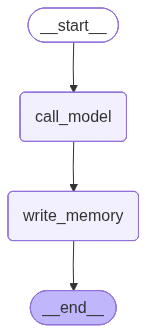

In [ ]:
from IPython.display import Image, display
import uuid
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.memory import InMemoryStore
from langchain_core.messages import merge_message_runs
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables.config import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.base import BaseStore

# 모델 초기화
model = ChatOpenAI(model="gpt-4.1-mini", temperature=0)


# 메모리 스키마
class Memory(BaseModel):
    content: str = Field(
        description="메모리의 주요 내용입니다. 예: 사용자가 프랑스어 학습에 관심을 보였습니다."
    )


# Trustcall 추출기 생성
trustcall_extractor = create_extractor(
    model,
    tools=[Memory],
    tool_choice="Memory",
    # 이를 통해 추출기가 새로운 메모리를 삽입할 수 있습니다
    enable_inserts=True,
)

# 챗봇 지시사항
MODEL_SYSTEM_MESSAGE = """당신은 도움이 되는 챗봇입니다. 당신은 사용자의 동반자가 되도록 설계되었습니다.\n
당신은 시간이 지남에 따라 사용자에 대해 배우는 정보를 추적하는 장기 기억을 가지고 있습니다.\n
현재 메모리 (이 대화에서 업데이트된 메모리를 포함할 수 있음):\n
{memory}"""

# Trustcall 지시사항
TRUSTCALL_INSTRUCTION = """다음 상호작용을 되돌아보세요.\n
제공된 도구를 사용하여 사용자에 대한 필요한 메모리를 유지하세요.\n
병렬 도구 호출을 사용하여 업데이트와 삽입을 동시에 처리하세요:"""


def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """저장소에서 메모리를 로드하고 이를 사용하여 챗봇의 응답을 개인화합니다."""

    # config에서 사용자 ID 가져오기
    user_id = config["configurable"]["user_id"]

    # 저장소에서 메모리 검색
    namespace = ("memories", user_id)
    memories = store.search(namespace)

    # 시스템 프롬프트를 위해 메모리 형식 지정
    info = "\n".join(f"- {mem.value['content']}" for mem in memories)
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=info)

    # 메모리와 채팅 기록을 사용하여 응답
    response = model.invoke([SystemMessage(content=system_msg)] + state["messages"])

    return {"messages": response}


def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """채팅 기록을 되돌아보고 메모리 컬렉션을 업데이트합니다."""

    # config에서 사용자 ID 가져오기
    user_id = config["configurable"]["user_id"]

    # 메모리의 네임스페이스 정의
    namespace = ("memories", user_id)

    # 컨텍스트를 위해 가장 최근 메모리 검색
    existing_items = store.search(namespace)

    # Trustcall 추출기를 위해 기존 메모리 형식 지정
    tool_name = "Memory"
    existing_memories = (
        [
            (existing_item.key, tool_name, existing_item.value)
            for existing_item in existing_items
        ]
        if existing_items
        else None
    )

    # 채팅 기록과 지시사항 병합
    updated_messages = list(
        merge_message_runs(
            messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION)] + state["messages"]
        )
    )

    # 추출기 호출
    result = trustcall_extractor.invoke(
        {"messages": updated_messages, "existing": existing_memories}
    )

    # Trustcall의 메모리를 저장소에 저장
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(
            namespace,
            rmeta.get("json_doc_id", str(uuid.uuid4())),
            r.model_dump(mode="json"),
        )


# 그래프 정의
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)

builder.set_entry_point("call_model")
builder.add_edge("call_model", "write_memory")
builder.set_finish_point("write_memory")

# 장기(스레드 간) 메모리를 위한 저장소
across_thread_memory = InMemoryStore()

# 단기(스레드 내) 메모리를 위한 체크포인터
within_thread_memory = MemorySaver()

# 체크포인터와 저장소로 그래프 컴파일
graph = builder.compile(
    checkpointer=within_thread_memory,
    store=across_thread_memory,
)

# 보기
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [ ]:
# 단기(스레드 내) 메모리를 위해 스레드 ID를 제공합니다
# 장기(스레드 간) 메모리를 위해 사용자 ID를 제공합니다
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# 사용자 입력
input_messages = [HumanMessage(content="안녕하세요, 제 이름은 Lance입니다")]

# 그래프 실행
for chunk in graph.stream(
    {"messages": input_messages},
    config,
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

안녕하세요, 제 이름은 Lance입니다
================================== Ai Message ==================================

안녕하세요, Lance! 만나서 반가워요. 오늘 어떻게 도와드릴까요?


In [ ]:
# 사용자 입력
input_messages = [
    HumanMessage(content="저는 샌프란시스코 주변에서 자전거 타는 것을 좋아합니다")
]

# 그래프 실행
for chunk in graph.stream(
    {"messages": input_messages},
    config,
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

저는 샌프란시스코 주변에서 자전거 타는 것을 좋아합니다
================================== Ai Message ==================================

샌프란시스코는 자전거 타기에 정말 멋진 장소죠! 특히 좋아하는 경로나 장소가 있나요?


In [52]:
# 저장할 메모리의 네임스페이스
user_id = "1"
namespace = ("memories", user_id)
memories = across_thread_memory.search(namespace)
for m in memories:
    print(m.dict())

{'namespace': ['memories', '1'], 'key': '62ef507d-28d5-4eb1-9a31-79e0bdc0ff78', 'value': {'content': '사용자의 이름은 Lance입니다.'}, 'created_at': '2025-10-02T08:34:10.073993+00:00', 'updated_at': '2025-10-02T08:34:10.073993+00:00', 'score': None}
{'namespace': ['memories', '1'], 'key': 'cc5ad87b-59d0-45fb-95a5-126db0d9c539', 'value': {'content': '사용자는 샌프란시스코 주변에서 자전거 타는 것을 좋아합니다.'}, 'created_at': '2025-10-02T08:34:10.074010+00:00', 'updated_at': '2025-10-02T08:34:10.074010+00:00', 'score': None}


In [ ]:
# 사용자 입력
input_messages = [HumanMessage(content="저는 빵집 가는 것도 즐깁니다")]

# 그래프 실행
for chunk in graph.stream(
    {"messages": input_messages},
    config,
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

저는 빵집 가는 것도 즐깁니다
================================== Ai Message ==================================

자전거를 타고 빵집에 가는 건 정말 좋은 조합이네요! 샌프란시스코에는 맛있는 빵집이 많죠. 특별히 좋아하는 빵집이 있나요?


새로운 스레드에서 대화를 계속합니다.

In [ ]:
# 단기(스레드 내) 메모리를 위해 스레드 ID를 제공합니다
# 장기(스레드 간) 메모리를 위해 사용자 ID를 제공합니다
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# 사용자 입력
input_messages = [HumanMessage(content="저에게 추천할 만한 빵집이 있나요?")]

# 그래프 실행
for chunk in graph.stream(
    {"messages": input_messages},
    config,
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

저에게 추천할 만한 빵집이 있나요?
================================== Ai Message ==================================

샌프란시스코에는 훌륭한 빵집이 많이 있습니다! 몇 가지 추천을 드리자면:

1. **타르틴 베이커리 (Tartine Bakery)** - 미션 지구에 위치한 이곳은 크루아상과 사워도우 빵으로 유명합니다.

2. **비 파티세리 (b. Patisserie)** - 이곳은 특히 크로캉트 아망드와 같은 페이스트리로 인기가 많습니다.

3. **아르스 타르틴 (Arsicault Bakery)** - 리치몬드 지구에 있으며, 버터리한 크루아상으로 많은 사랑을 받고 있습니다.

4. **파니에 (Le Marais Bakery)** - 프랑스 스타일의 빵과 페이스트리를 즐길 수 있는 곳입니다.

이 중에서 가보지 않은 곳이 있다면 한 번 방문해 보세요! 자전거로 가기에도 좋은 경로가 있을 것 같네요.


### LangSmith 

https://smith.langchain.com/public/c87543ec-b426-4a82-a3ab-94d01c01d9f4/r

## 스튜디오

![Screenshot 2024-10-30 at 11.29.25 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/6732d0876d3daa19fef993ba_Screenshot%202024-11-11%20at%207.50.21%E2%80%AFPM.png)